In [22]:
import logging
import pandas as pd
import matplotlib.pyplot as plt
import joblib

from models.topic_analisis.mod_01_tweets_tokenization import (
    tokenize_tweets,
    dictionary_tweets,
    bow_tweets,
    train_bow_tweets)

from msmrh_btm.models.btm_em import bag_biterms, BTM_EM

In [44]:
# Output constants:
store_path= '/Users/hpp/PycharmProjects/tfm_hugopobil/models/topic_analisis'
name_tmpl = 'btm_em_tfm'
n_topics_list = [5, 10, 15, 20]

model_fn_map = {
    n_topics: f'{store_path}/{name_tmpl}{n_topics}.joblib'
    for n_topics in n_topics_list
}

# Set the language for dictionary formulas
lang= 'en'

In [36]:
X = joblib.load('/home/hugopobil/PycharmProjects/mrh_i3_twitter/scratches/hpobil/analisis_tweets_neurona_podemos_bankinter/X_tweets_nlp_processed.joblib')
tweets = pd.read_csv('/home/hugopobil/PycharmProjects/mrh_i3_twitter/scratches/hpobil/analisis_tweets_neurona_podemos_bankinter/tweets_nlp_modelling_v3.csv')

In [37]:
tweets['tokens'] = tokenize_tweets(tweets.cleaned_tweets.to_list(), lang='en')

In [38]:
words_to_delete = ['Bitcoin', 'btc', 'ada', 'bitcoin']

for word in words_to_delete:
    tweets['tokens'] = tweets.tokens.apply(lambda x: [i for i in x if i != word])

dictionary = dictionary_tweets(tweets['tokens'])

2022-04-08 20:34:38,699 : INFO : MainProcess : 111559 : adding document #0 to Dictionary(0 unique tokens: [])
2022-04-08 20:34:38,804 : INFO : MainProcess : 111559 : adding document #10000 to Dictionary(22661 unique tokens: ['ehsnhs', 'institutional', 'investment', 'pouring', 'qen']...)
2022-04-08 20:34:38,925 : INFO : MainProcess : 111559 : adding document #20000 to Dictionary(38314 unique tokens: ['ehsnhs', 'institutional', 'investment', 'pouring', 'qen']...)
2022-04-08 20:34:38,931 : INFO : MainProcess : 111559 : built Dictionary(39012 unique tokens: ['ehsnhs', 'institutional', 'investment', 'pouring', 'qen']...) from 20565 documents (total 257358 corpus positions)
2022-04-08 20:34:38,939 : INFO : MainProcess : 111559 : Dictionary lifecycle event {'msg': "built Dictionary(39012 unique tokens: ['ehsnhs', 'institutional', 'investment', 'pouring', 'qen']...) from 20565 documents (total 257358 corpus positions)", 'datetime': '2022-04-08T20:34:38.931876', 'gensim': '4.1.2', 'python': '3.

In [39]:
# BOW and X creation:
X = bow_tweets(tweets['tokens'], dictionary)

X_train = train_bow_tweets(X, min_n_words=3)
print(f'X.shape:       {X.shape}')
print(f'X_train.shape: {X_train.shape}')

X.shape:       (20565, 39012)
X_train.shape: (19180, 39012)


### Biterm analysis

In [40]:
#Here we show an histogram of biterms:

bob = bag_biterms(X)
bob_df = pd.DataFrame((list(map(str, bob))), columns=['biterms']).groupby(['biterms']).size().reset_index(name='counts').sort_values('counts', ascending=0)
bob_df['biterm_text'] = bob_df['biterms'].apply(lambda x: x.strip(' []').split(' '))

In [41]:
bob_df

,biterms,counts,biterm_text
887646,[38 39],1676,"[38, 39]"
430711,[ 38 153],1428,"[38, 153]"
430859,[ 38 353],1282,"[38, 353]"
430990,[ 38 544],1047,"[38, 544]"
731000,[153 353],984,"[153, 353]"
...,...,...,...
341714,[ 2129 26120],1,"[2129, 26120]"
341715,[ 2129 26327],1,"[2129, 26327]"
341716,[ 2129 27082],1,"[2129, 27082]"
341717,[ 2129 27346],1,"[2129, 27346]"


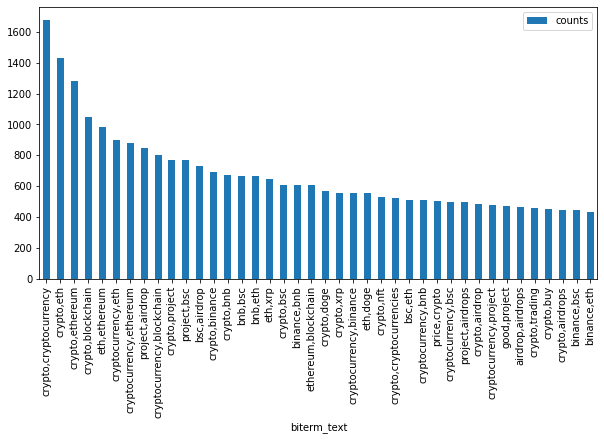

In [42]:
bob_df['biterm_text'] = bob_df['biterm_text'].apply(lambda x: f'{dictionary[int(x[0])]},{dictionary[int(x[1])]}')
ax =  bob_df[0:40].plot.bar(x='biterm_text' ,y='counts', figsize=(10,5))
plt.show()

### Topic (BTM) creation (slow, only once)

In [43]:
# It st
prms = {'verbose':1,
        'log_every':500,
        'max_iter':10000,
        'score_precision':1e-7,
        'check_score_every':100}


def btm_fit(n_topics, X):
    logging.info(f'btm.fit(n_topics={n_topics})')

    btm = BTM_EM(n_topics=n_topics, alpha=50/n_topics,**prms)
    btm.fit(X)
    return btm

with joblib.Parallel(n_jobs=len(n_topics_list), prefer='threads') as parallel:
    btm_list = parallel(
        joblib.delayed(btm_fit)(n_topics, X_train) for n_topics in n_topics_list
    )

2022-04-08 20:36:03,361 : INFO : MainProcess : 111559 : btm.fit(n_topics=5)
2022-04-08 20:36:03,361 : INFO : MainProcess : 111559 : btm.fit(n_topics=10)
2022-04-08 20:36:03,361 : INFO : MainProcess : 111559 : btm.fit(n_topics=15)
2022-04-08 20:36:03,362 : INFO : MainProcess : 111559 : btm.fit(n_topics=20)
2022-04-08 20:36:31,989 : INFO : MainProcess : 111559 : Last iteration (400 of max_iter: 10000): score(p): 27018988.7124, δp/score_tol: -167.2883,(δp/p)/score_precision: 0.6191 
2022-04-08 20:36:31,989 : INFO : MainProcess : 111559 : Convergence of score achieved
2022-04-08 20:36:42,287 : INFO : MainProcess : 111559 : Iteration: 500 of max_iter: 10000, score(p): 26706797.4689, δp/score_tol: -7967.9858,(δp/p)/score_precision: 29.8261 
2022-04-08 20:36:53,299 : INFO : MainProcess : 111559 : Iteration: 500 of max_iter: 10000, score(p): 26538853.8237, δp/score_tol: -1924.7700,(δp/p)/score_precision: 7.2521 
2022-04-08 20:36:58,250 : INFO : MainProcess : 111559 : Last iteration (900 of max

### Save objects to s3

In [46]:
# Store them in s3:
for btm in btm_list:
    fn = model_fn_map[btm.n_topics]
    print(fn)
    joblib.dump(btm, fn)

/home/hugopobil/PycharmProjects/mrh_i3_twitter/scratches/hpobil/analisis_tweets_neurona_podemos_bankinter/models/btm_em_tfm5.joblib
/home/hugopobil/PycharmProjects/mrh_i3_twitter/scratches/hpobil/analisis_tweets_neurona_podemos_bankinter/models/btm_em_tfm10.joblib
/home/hugopobil/PycharmProjects/mrh_i3_twitter/scratches/hpobil/analisis_tweets_neurona_podemos_bankinter/models/btm_em_tfm15.joblib
/home/hugopobil/PycharmProjects/mrh_i3_twitter/scratches/hpobil/analisis_tweets_neurona_podemos_bankinter/models/btm_em_tfm20.joblib
